In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np

In [ ]:
# import traceback
# import warnings
# import sys

# def warn_with_traceback(message, category, filename, lineno, file=None, line=None):

#     log = file if hasattr(file,'write') else sys.stderr
#     traceback.print_stack(file=log)
#     log.write(warnings.formatwarning(message, category, filename, lineno, line))

# warnings.showwarning = warn_with_traceback

In [ ]:
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles_copy as cpc
m_per_nm = fit.m_per_nm

from misloc_mispol_package.optics import diffraction_int as diffi
    hres_obs_pts = diffi.observation_points(-480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [ ]:
fit.fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=125, y_max=125)

In [ ]:
just_mols_i_want = [
    np.vstack((
        fit.fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=125, y_max=125)[0][7],
        fit.fixed_ori_mol_placement(mol_grid_pts_1D=5, x_max=125, y_max=125)[0][-1],
        )),
    0
    ]

In [ ]:
just_mols_i_want

In [ ]:
locations_100, angles_100 = just_mols_i_want
simTestInst_few_mol_h_100 = bem.SimulatedExperiment(locations_100, mol_angle=0, obs_points=hres_obs_pts)
simTestInst_few_mol_h_100.trial_images = simTestInst_few_mol_h_100.calculate_BEM_fields()

simTestInst_few_mol_h_100.plot_mispol_map_wMisloc()

In [ ]:
# Model fit
# Gaussian guess, checked

test_BEM_fit_instance_few_mol_h_100 = fit.FitModelToData(
    simTestInst_few_mol_h_100.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    obs_points=hres_obs_pts
    )
test_BEM_fit_few_mol_h_100 = test_BEM_fit_instance_few_mol_h_100.fit_model_to_image_data(
    check_ini=True)

## Plot fit results
test_BEM_fit_instance_few_mol_h_100.plot_fit_results_as_quiver_map(simTestInst_few_mol_h_100)   

Save datas

In [ ]:
# bem.save_fit_inst(test_BEM_fit_instance_few_mol_h_100, simTestInst_few_mol_h_100, 'fig5/')
bem.save_sim_exp_inst(simTestInst_few_mol_h_100, 'fig5/sim/')


Test load

In [ ]:
loaded_fit_inst = bem.LoadedFit('fig5/fig5')

In [ ]:
fig5 = bem.fig5(simTestInst_few_mol_h_100, test_BEM_fit_instance_few_mol_h_100, draw_quadrant=True)

modifying plotting function to suit Julie's requests

In [ ]:
fig5.savefig('fig5.pdf', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None, metadata=None)

In [ ]:
simTestInst_few_mol_h_100.BEM_images

In [ ]:
simTestInst_few_mol_h_100.BEM_images.shape

In [ ]:
test_BEM_fit_instance_few_mol_h_100.model_fit_results

In [ ]:

import matplotlib.pyplot as plt
import matplotlib as mpl

# inspired by http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 8, # fontsize for x and y labels (was 10)
    'axes.titlesize': 8,
    'font.size': 8, # was 10
    'legend.fontsize': 6, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)

## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable
#         ## Add colorbar
#         divider = make_axes_locatable(axs[ax_idx])
#         cax1 = divider.append_axes("right", size="5%", pad=0.05)
#         fig.colorbar(img1, cax=cax1)


In [ ]:
simTestInst_few_mol_h_100.BEM_images[i].shape

In [ ]:
import scipy.optimize as opt

In [ ]:
def gauss_from_params(
    params,
#     resolution=None,
    ):
    """ 
        Args
        ----
        
        params = [
            d=[x, y, z], : mol location relative to plasmon
            phi, : mole angle
            ]
    
        """
    dx = params[0]
    dy = params[1]
    phi = params[2]
    
#     if resolution is None:
#         obs_pts = None
#     else:
    obs_pts = hres_obs_pts
        
#     cp_inst=cpc.CoupledDipoles(obs_points=obs_pts)
    raveled_image = fit.FittingTools.twoD_Gaussian(None, 
        (obs_pts[1]/m_per_nm, obs_pts[2]/m_per_nm), ## tuple of meshed (x,y) values
        *params
        )
    
    raveled_image = raveled_image.ravel()
    
    return raveled_image
    
    
def fit_image_w_gaussian(image, ini_guess_params=None):
    """
        """
    data = image
    model = lambda params: gauss_from_params(params)
    
#     cost_func = 
    if ini_guess_params is None: 
        ini_guess_params = (1, 100, 100, 100, 100, 0, 0)
    
    fit_result = opt.least_squares(
        lambda fit_params: (
            data.ravel()/data.max() 
            - 
            model(fit_params).ravel()/ model(fit_params).max()
            ),
        ini_guess_params,
#         x_scale=[1E2,1E2,1],
        loss='soft_l1'
        )
    
    return fit_result


In [ ]:
gauss_fit_result = []


for i, image in enumerate(simTestInst_few_mol_h_100.BEM_images):


    gauss_fit_result.append(fit_image_w_gaussian(image))


# ## Fit Gaussian
# gauss_fit_result.append( 
#     gauss_fit_inst.fit_model(
#         np.asarray([
#             simTestInst_few_mol_h_100.BEM_images[i].reshape(201,201)
#             ]),
#         )
#    )
    

In [ ]:
gauss_fit_result[0]['x']

In [248]:
# Draw the rod and ellipse
import matplotlib as mpl
curly_nanorod_color = (241/255, 223/255, 182/255)
curly_nanorod_color_light = (241/255, 223/255, 182/255, 0.5)

def draw_rod(ax, xy_coords, color=curly_nanorod_color):
    
    out_circle = mpl.patches.Circle(
        (xy_coords[1]+0, xy_coords[0]+24),
        22,
        # facecolor='Gold',
        facecolor='k',
        edgecolor='Black',
        linewidth=0,
        )
    out_bot_circle = mpl.patches.Circle(
        (xy_coords[1]-0, xy_coords[0]-24),
        22,
        # facecolor='Gold',
        facecolor='k',
        edgecolor='Black',
        linewidth=0,
        )
    out_rect = mpl.patches.Rectangle(
        (xy_coords[1]-22,xy_coords[0]-24),
        44,
        48,
        angle=0.0,
        # facecolor='Gold',
        facecolor='k',
        edgecolor='Black',
        linewidth=0,
        )
    
    circle = mpl.patches.Circle(
        (xy_coords[1]+0, xy_coords[0]+24),
        20,
        # facecolor='Gold',
        facecolor=color,
        edgecolor='Black',
        linewidth=0,
        )
    bot_circle = mpl.patches.Circle(
        (xy_coords[1]-0, xy_coords[0]-24),
        20,
        # facecolor='Gold',
        facecolor=color,
        edgecolor='Black',
        linewidth=0,
        )
    rect = mpl.patches.Rectangle(
        (xy_coords[1]-19.75,xy_coords[0]-24),
        40.5,
        48,
        angle=0.0,
        # facecolor='Gold',
        facecolor=color,
        edgecolor='Black',
        linewidth=0,
        )
    # for piece in rod:
    ax.add_patch(out_circle)
    ax.add_patch(out_bot_circle)
    ax.add_patch(out_rect)
    
    ax.add_patch(circle)
    ax.add_patch(bot_circle)
    ax.add_patch(rect)
    
    return ax

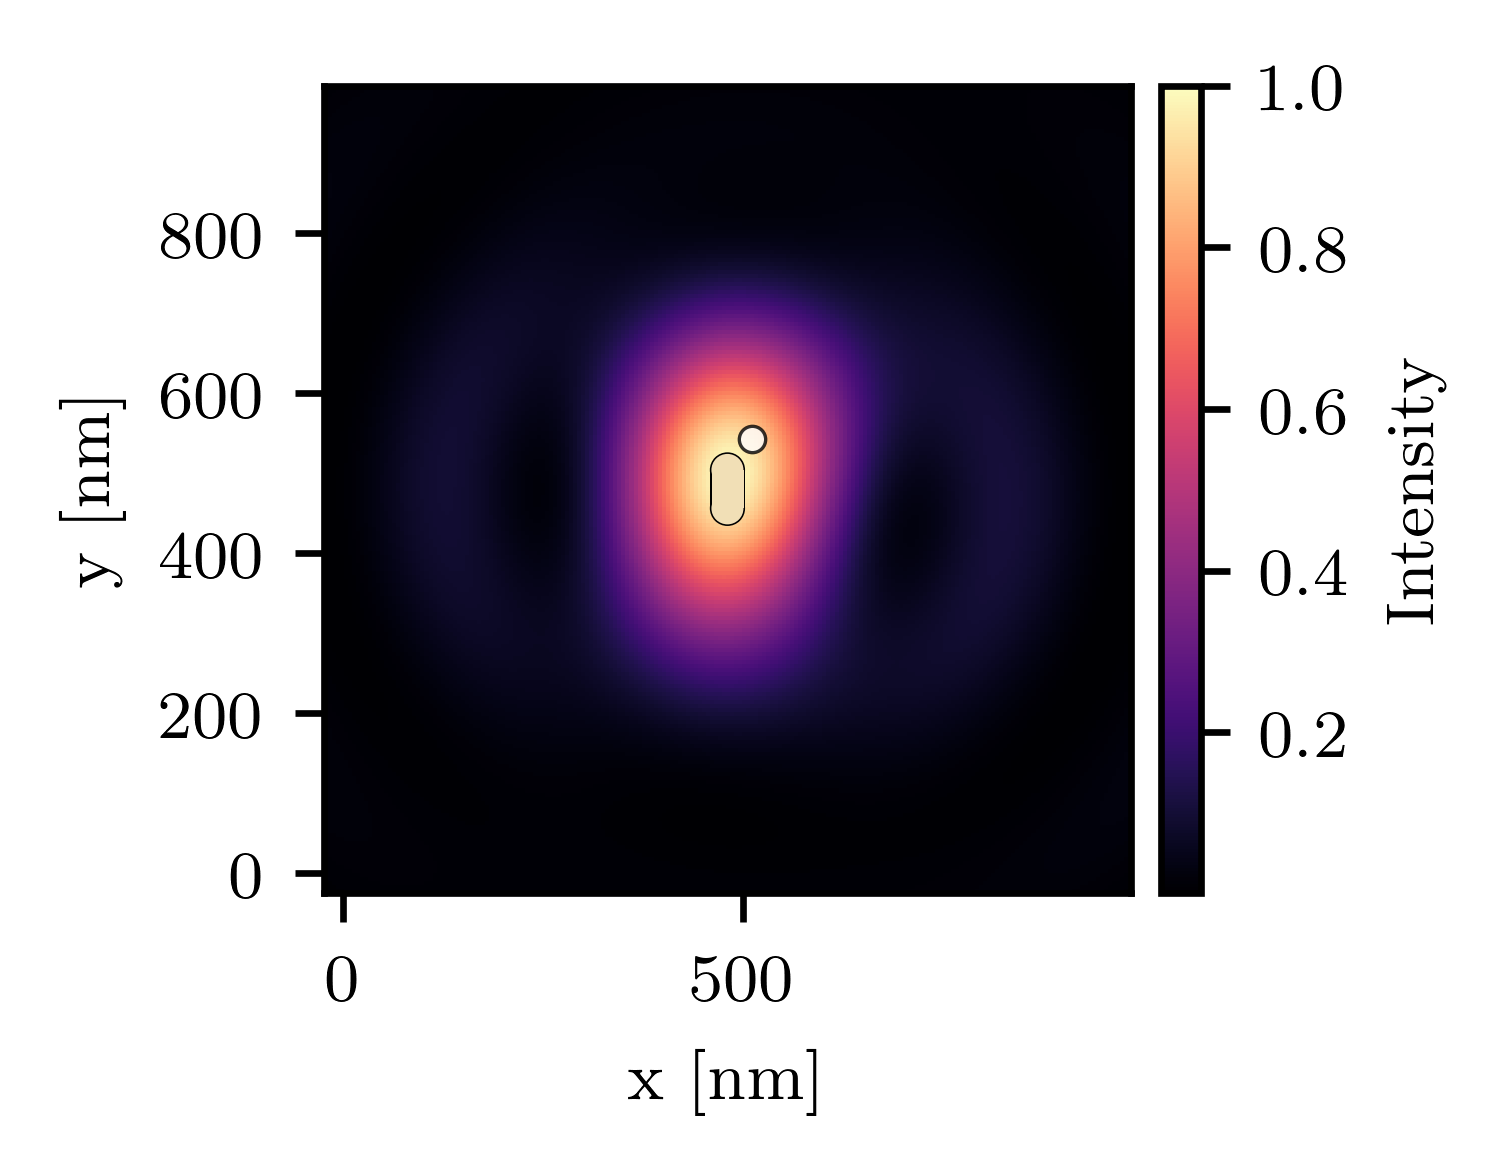

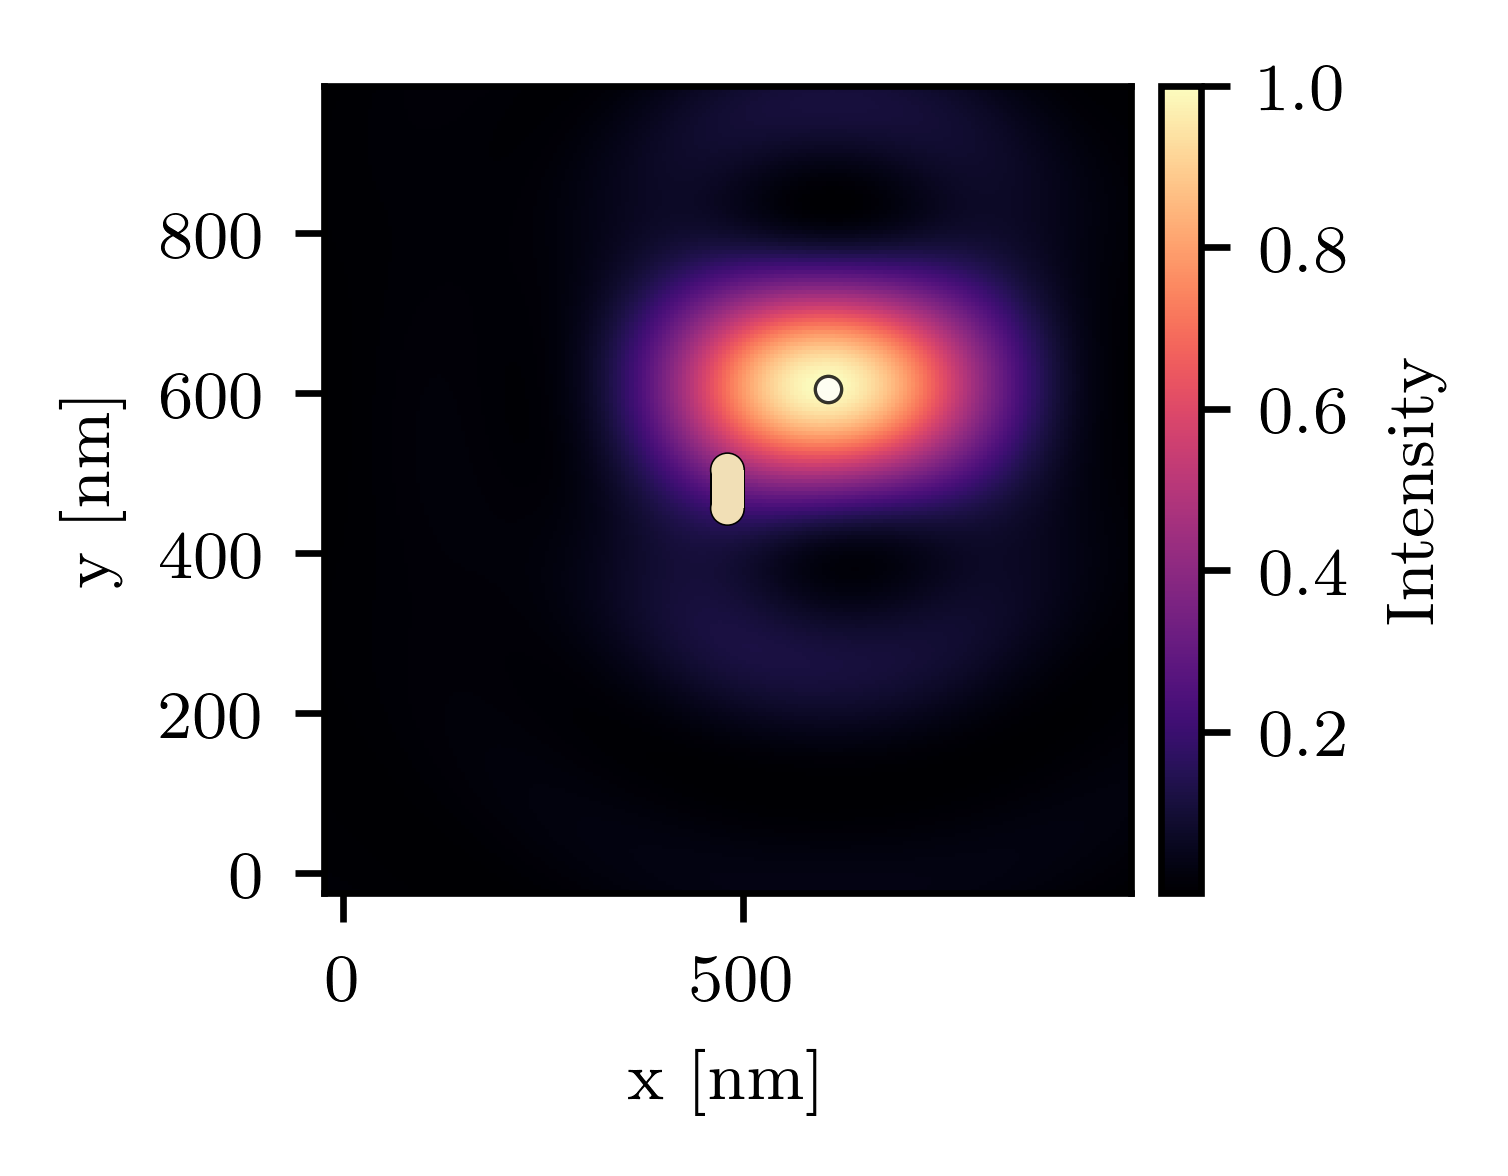

In [249]:

for i in [0, 1]:

    fig, axs = plt.subplots(
        ncols=1,
        dpi=600,
        figsize=(6,2)
        )

    img1 = axs.imshow(
        simTestInst_few_mol_h_100.BEM_images[i].reshape(201,201).T/simTestInst_few_mol_h_100.BEM_images[i].max(),
        origin='lower',
        extent=[0-48/2, 48*21-48/2, 0-48/2, 48*21-48/2]
        )

    ## Add colorbar
    divider = make_axes_locatable(axs)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1, label='Intensity')

    axs.set_xlabel('x [nm]')
    axs.set_ylabel('y [nm]')

    plt.tight_layout(h_pad=1)


#     axs.contour(
#         np.linspace(0,48*(21-1),201),
#         np.linspace(0,48*(21-1),201),
#         fit.FittingTools.twoD_Gaussian(
#             None,
#             (hres_obs_pts[1]/m_per_nm, hres_obs_pts[2]/m_per_nm),
#             *gauss_fit_result[i]['x']
#             ).reshape(hres_obs_pts[1].shape),
#         cmap='Wistia',
#         linewidths=0.5,
#         levels=4
#         )
    
    ## scatter mol position
    axs.scatter(
        simTestInst_few_mol_h_100.mol_locations[i][0]+480,
        simTestInst_few_mol_h_100.mol_locations[i][1]+480,
        s = 10,
        c='w',
        alpha=.8,
        edgecolor='k',
        linewidth=.4
        )

    draw_rod(axs, [480,480])

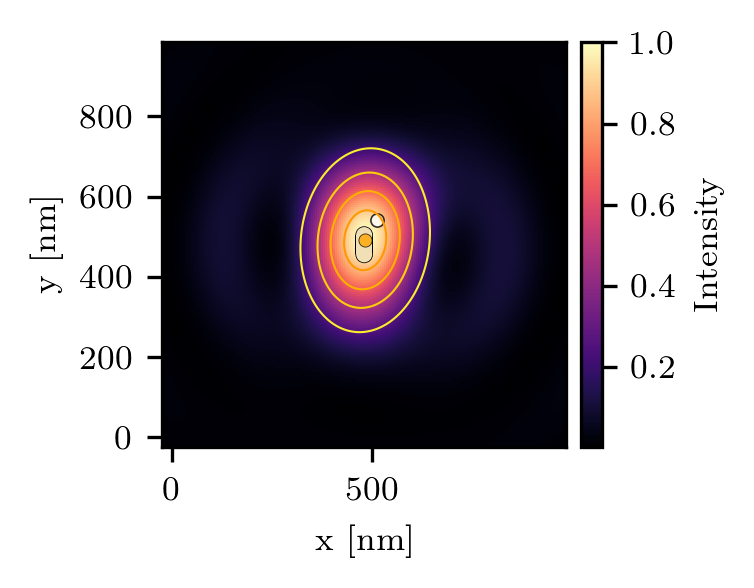

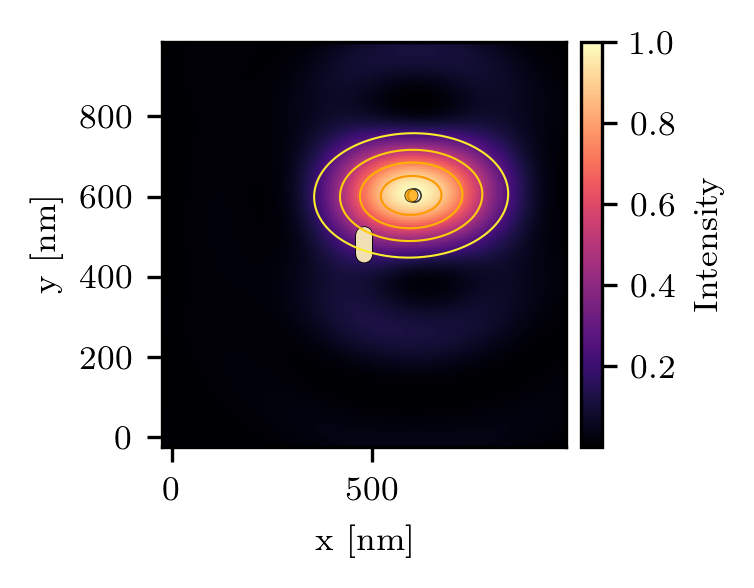

In [235]:

for i in [0, 1]:

    fig, axs = plt.subplots(
        ncols=1,
        dpi=300,
        figsize=(6,2)
        )

    img1 = axs.imshow(
        simTestInst_few_mol_h_100.BEM_images[i].reshape(201,201).T/simTestInst_few_mol_h_100.BEM_images[i].max(),
        origin='lower',
        extent=[0-48/2, 48*21-48/2, 0-48/2, 48*21-48/2]
        )

    ## Add colorbar
    divider = make_axes_locatable(axs)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1, label='Intensity')

    axs.set_xlabel('x [nm]')
    axs.set_ylabel('y [nm]')
    plt.tight_layout(h_pad=1)


    axs.contour(
        np.linspace(0,48*(21-1),201),
        np.linspace(0,48*(21-1),201),
        fit.FittingTools.twoD_Gaussian(
            None,
            (hres_obs_pts[2]/m_per_nm, hres_obs_pts[1]/m_per_nm,),
            *gauss_fit_result[i]['x']
            ).reshape(hres_obs_pts[1].shape),
        cmap='Wistia',
        linewidths=0.5,
        levels=4
        )
    
    ## scatter gaussian position
    axs.scatter(
        gauss_fit_result[i]['x'][1]+480,
        gauss_fit_result[i]['x'][2]+480,
        s = 10,
        c='orange',
        alpha=.8,
        edgecolor='k',
        linewidth=.2,
        zorder=5
        )
    
        ## scatter mol position
    axs.scatter(
        simTestInst_few_mol_h_100.mol_locations[i][0]+480,
        simTestInst_few_mol_h_100.mol_locations[i][1]+480,
        s = 10,
        c='w',
        alpha=.8,
        edgecolor='k',
        linewidth=.4
        )

    draw_rod(axs, [480,480])

In [237]:
def image_from_params(
    params, 
    plas_loc,
    resolution=None,
    ):
    """ 
        Args
        ----
        
        params = [
            d=[x, y, z], : mol location relative to plasmon
            phi, : mole angle
            ]
    
        """
    dx = params[0]
    dy = params[1]
    phi = params[2]
    
    if resolution is None:
        obs_pts = None
    else:
        obs_pts = diffi.observation_points(
            0, 48*20*m_per_nm, 0, 48*20*m_per_nm, resolution)
        
    cp_inst=CoupledDipoles(obs_points=obs_pts)
    field_output = cp_inst.dipole_fields(
            np.array([[dx, dy, 0]]), 
            mol_angle=phi, 
            plas_angle=0, 
            plas_centroid=np.array([plas_loc])
            )
    raveled_image = cp_inst.image_from_E(field_output[0]+field_output[1])
    
    return raveled_image
    
    
def fit_image_w_coupled_model(image, plas_loc, ini_guess_params=None):
    """
        """
    data = image
    model = lambda params: image_from_params(params, plas_loc)
    
#     cost_func = 
    if ini_guess_params is None: 
        ini_guess_params = (100, 100, 0)
    
    fit_result = opt.least_squares(
        lambda fit_params: (
            data.ravel()/data.max() 
            - 
            model(fit_params).ravel()/ model(fit_params).max()
            ),
        ini_guess_params,
        x_scale=[1E2,1E2,1],
        loss='soft_l1'
        )
    
    return fit_result


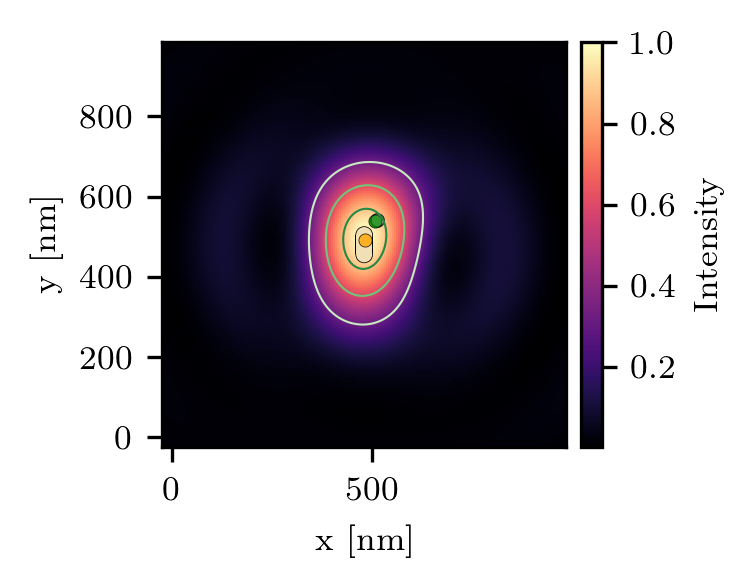

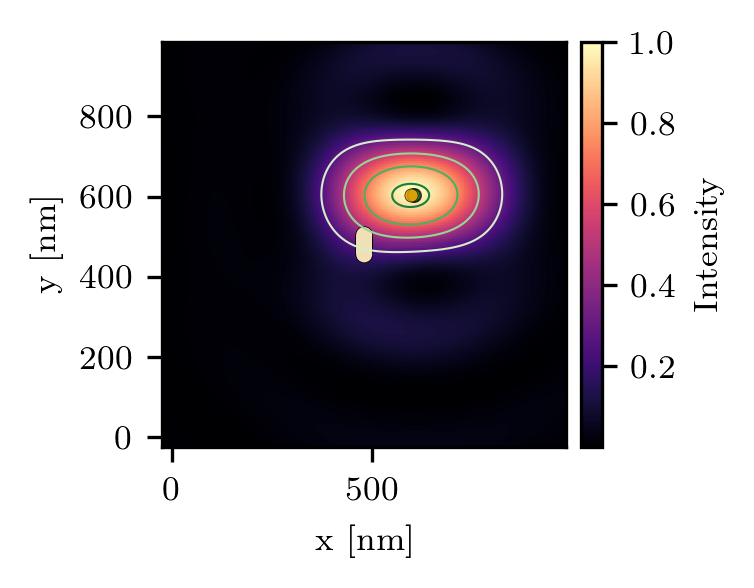

In [240]:
## Fit model
for i in [0, 1]:

    fig, axs = plt.subplots(
        ncols=1,
        dpi=300,
        figsize=(6,2)
        )

    img1 = axs.imshow(
        simTestInst_few_mol_h_100.BEM_images[i].reshape(201,201).T/simTestInst_few_mol_h_100.BEM_images[i].max(),
        origin='lower',
        extent=[0-48/2, 48*21-48/2, 0-48/2, 48*21-48/2]
        )

    ## Add colorbar
    divider = make_axes_locatable(axs)
    cax1 = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, cax=cax1, label='Intensity')

    axs.set_xlabel('x [nm]')
    axs.set_ylabel('y [nm]')

    plt.tight_layout(h_pad=1)


    axs.contour(
        np.linspace(0,48*(21-1),201),
        np.linspace(0,48*(21-1),201),
        test_BEM_fit_instance_few_mol_h_100.raveled_model_of_params(
            test_BEM_fit_instance_few_mol_h_100.model_fit_results[i],
            ).reshape(hres_obs_pts[1].shape).T,
        cmap='Greens',
        linewidths=0.5,
        levels=4
        )

        ## scatter mol position
    axs.scatter(
        simTestInst_few_mol_h_100.mol_locations[i][0]+480,
        simTestInst_few_mol_h_100.mol_locations[i][1]+480,
        s = 10,
        c='w',
        alpha=.8,
        edgecolor='k',
        linewidth=.4
        )
    
    ## scatter gaussian position
    axs.scatter(
        test_BEM_fit_instance_few_mol_h_100.model_fit_results[i][0]+480,
        test_BEM_fit_instance_few_mol_h_100.model_fit_results[i][1]+480,
        s = 10,
        c='green',
        alpha=.8,
        edgecolor='k',
        linewidth=.2
        )
    
    ## scatter gaussian position
    axs.scatter(
        gauss_fit_result[i]['x'][1]+480,
        gauss_fit_result[i]['x'][2]+480,
        s = 10,
        c='orange',
        alpha=.8,
        edgecolor='k',
        linewidth=.2,
        zorder=5
        )

    draw_rod(axs, [480,480])